# Data Cleaning/EDA

In [1]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset
from surprise import KNNBasic
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import SVDpp
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import GridSearchCV
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def vanilla_model(data):
    
    
    knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=-1, verbose=True)
    knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=-1, verbose=True)
    knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=-1, verbose=True)


    svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=-1, verbose=True)
    svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=-1, verbose=True)
    nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=-1, verbose=True)

In [3]:
ratings_df = pd.read_csv('ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings_df.shape

(100836, 4)

In [5]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [8]:
ratings_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [9]:
new_ratings_df = ratings_df.drop(columns='timestamp')

### Histogram of the number of users per rating

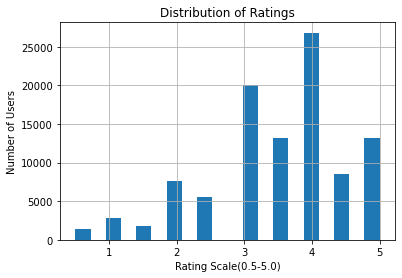

In [10]:
new_ratings_df['rating'].hist(bins=20)

plt.title('Distribution of Ratings')
  
plt.xlabel('Rating Scale(0.5-5.0)')
plt.ylabel('Number of Users');

As the graph aboves illustrates, on a scale of 0.5-5.0, most users rated movies they watched 3.0 or 4.0.

# Collaborative Filtering

In [11]:
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(new_ratings_df,reader)

In [12]:
train, test = train_test_split(data, test_size=.2)

In [13]:
vanilla_model(data)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9519  0.9542  0.9446  0.9414  0.9474  0.9479  0.0047  
MAE (testset)     0.7288  0.7306  0.7246  0.7232  0.7254  0.7265  0.0027  
Fit time          0.07    0.07    0.07    0.07    0.06    0.07    0.01    
Test time         1.15    1.14    1.07    1.09    1.08    1.11    0.03    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9027  0.8868  0.9061  0.8999  0.8905  0.8972  0.0073  
MAE (testset)     0.6891  0.6796  0.6930  0.6864  0.6800  0.6856  0.0052  
Fit time          0.08    0.09    0.07    0.07    0.07    0.07    0.01    
Test time         1.31    1.27    1.27    1.28    1.23    1.27    0.03    
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean  

In [14]:
def run_model(model):
    
    model.fit(train)
    predictions = model.test(test)
    acc = accuracy.rmse(predictions)

    return model

In [15]:
svd_model = SVD()

run_model(svd_model)

RMSE: 0.8813


In [16]:
svdpp_model = SVDpp()

run_model(svdpp_model)

RMSE: 0.8688


# Hyperparameter Tuning using GridSearch

In [17]:
data = Dataset.load_from_df(new_ratings_df, reader)

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8947315272862967
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [18]:
data = Dataset.load_from_df(new_ratings_df, reader)

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8932919938039666
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


Based on the results of the GridSearch tuning, the SVD model performed slightly better than the SVDpp. I ran another GridSearch tuning of the SVD model, modifying the number of epochs, learning rate and regularization, while also including n_factors into the tuning process:

In [19]:
data = Dataset.load_from_df(new_ratings_df, reader)

param_grid = {'n_epochs': [10, 25, 50], 'lr_all': [0.02, 0.0005, 0.001],
              'reg_all': [0.01, 0.06, 0.1, 0.5], 'n_factors': [50, 100, 150]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8590893064447886
{'n_epochs': 50, 'lr_all': 0.02, 'reg_all': 0.1, 'n_factors': 150}


In [20]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [21]:
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,...,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all,param_n_factors
0,0.907431,0.904509,0.894238,0.902059,0.005658,60,0.697111,0.690207,0.687570,0.691629,...,38,0.966740,0.002284,0.198157,0.036951,"{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0....",10,0.02,0.01,50
1,0.904339,0.903459,0.898526,0.902108,0.002558,61,0.696636,0.692793,0.691546,0.693658,...,42,1.570842,0.007582,0.184392,0.025896,"{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0....",10,0.02,0.01,100
2,0.906102,0.902116,0.898371,0.902196,0.003157,62,0.699005,0.693944,0.694361,0.695770,...,52,2.150541,0.023597,0.161635,0.033620,"{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0....",10,0.02,0.01,150
3,0.871376,0.872535,0.862365,0.868759,0.004546,12,0.669270,0.668098,0.664708,0.667359,...,14,0.898646,0.004133,0.169467,0.027302,"{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0....",10,0.02,0.06,50
4,0.874388,0.870761,0.861133,0.868760,0.005593,13,0.670377,0.666502,0.663223,0.666701,...,13,1.527982,0.002359,0.171665,0.028061,"{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0....",10,0.02,0.06,100


# Final Model

I used SVD as my final model. I created a residual plot to show the actual ratings compared to the predictive ratings:

In [22]:
def predict_rating(row):
    return svd_model.predict(row['userId'], row['movieId'])[3]

In [23]:
new_ratings_df['predicted_rating'] = new_ratings_df.apply(predict_rating, axis=1)
new_ratings_df.head()

,userId,movieId,rating,predicted_rating
0,1,1,4.0,4.579752
1,1,3,4.0,3.815030
2,1,6,4.0,4.512103
3,1,47,5.0,4.794261
4,1,50,5.0,5.000000


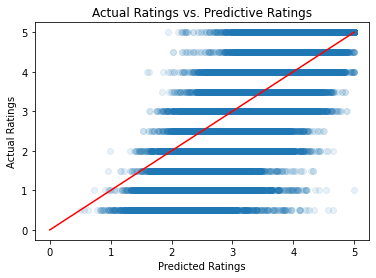

In [24]:
plt.scatter(new_ratings_df['predicted_rating'], new_ratings_df['rating'], alpha=0.1)
plt.plot([0, 5], [0, 5], color='red', linestyle='-')
plt.title('Actual Ratings vs. Predictive Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

The scatter plot above shows ratings of 3, 4, and 5 were underpredicted, while ratings ratings of 1 and 2 were overpredicted. This illustrates how this recommendation system model may recommend movies that users gave a low rating (1 and 2), and not recommend movies that were highly-rated by users (4 and 5). 

(array([4.0000e+00, 1.3000e+01, 4.1000e+01, 1.1200e+02, 2.7900e+02,
        6.0100e+02, 1.2720e+03, 2.3970e+03, 4.7530e+03, 9.3150e+03,
        1.6370e+04, 2.2911e+04, 2.1645e+04, 1.3461e+04, 5.6130e+03,
        1.5700e+03, 3.5800e+02, 9.0000e+01, 1.9000e+01, 1.2000e+01]),
 array([-4.15892011, -3.79796644, -3.43701277, -3.0760591 , -2.71510543,
        -2.35415176, -1.99319809, -1.63224442, -1.27129075, -0.91033708,
        -0.54938342, -0.18842975,  0.17252392,  0.53347759,  0.89443126,
         1.25538493,  1.6163386 ,  1.97729227,  2.33824594,  2.69919961,
         3.06015328]),
 <BarContainer object of 20 artists>)

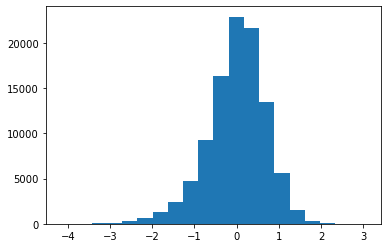

In [25]:
plt.hist(new_ratings_df['rating'] - new_ratings_df['predicted_rating'], bins=20)

As the plot above shows, the residual error of predicted ratings was between 1 and -1.

# Predicting Ratings of New Users

In [26]:
svd_model.predict(4, 28)

Prediction(uid=4, iid=28, r_ui=None, est=3.6531265875582406, details={'was_impossible': False})

In [27]:
movies_df = pd.read_csv('movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [28]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [29]:
movies_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [30]:
def movie_rater(movies_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movies_df[movies_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movies_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [32]:
user_rating = movie_rater(movies_df, 4, 'Comedy')

      movieId          title                       genres
5235     8578  Undead (2003)  Action|Comedy|Horror|Sci-Fi
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId             title        genres
2997     4012  Punchline (1988)  Comedy|Drama
How do you rate this movie on a scale of 1-5, press n if you have not seen :
2
      movieId                    title                genres
9126   146244  Dil To Pagal Hai (1997)  Comedy|Drama|Romance
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
      movieId                 title                genres
6781    60293  Wackness, The (2008)  Comedy|Drama|Romance
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4


### Adding New Ratings to Original ratings DataFrame

In [33]:
movie_ratings_df = new_ratings_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(movie_ratings_df[['userId', 'movieId', 'rating']], reader)

### Train Model Using Combined DataFrame

In [34]:
svd_ = SVD(n_epochs=50, lr_all=0.02, reg_all=0.1, n_factors=150)
svd_.fit(new_data.build_full_trainset())

### Making Predictions for New User

In [35]:
list_of_movies = []
for m_id in movies_df['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [36]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [37]:
print(list(ranked_movies))

[(8578, 4.740291629450915), (8477, 4.733440964434456), (78836, 4.693219027305285), (6818, 4.577014061853877), (5772, 4.537470917488909), (177593, 4.526515259008439), (7071, 4.5179619255993115), (7121, 4.513721901193845), (3473, 4.490627553260685), (6442, 4.482246999309495), (33649, 4.473681188372713), (3451, 4.469327895821036), (2295, 4.466235437377597), (7008, 4.463047784166408), (74282, 4.460199472496666), (6460, 4.449800602147133), (132333, 4.445672505004223), (4495, 4.444982138265486), (30745, 4.441279516982609), (2732, 4.4334572651211985), (80083, 4.4331246322680276), (2131, 4.432703801534007), (97866, 4.424582195326782), (26073, 4.417581555932008), (5889, 4.414835248058106), (32582, 4.413792518385163), (67618, 4.410508602063426), (142115, 4.410221473668209), (171495, 4.409875894366448), (27156, 4.408849129815704), (25906, 4.407589934960857), (152105, 4.404570390720946), (6666, 4.402700038957775), (38095, 4.398360324725668), (5915, 4.393566294351676), (33779, 4.382849054180965), (

In [38]:
predicted_movie_ratings = pd.DataFrame(list(ranked_movies), columns=['movieId', 'movie_rating'])
predicted_movie_ratings.head()

,movieId,movie_rating
0,8578,4.740292
1,8477,4.733441
2,78836,4.693219
3,6818,4.577014
4,5772,4.537471


In [39]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies_df,5)

Recommendation #  1 :  5235    Undead (2003)
Name: title, dtype: object 

Recommendation #  2 :  5202    Jetée, La (1962)
Name: title, dtype: object 

Recommendation #  3 :  7364    Enter the Void (2009)
Name: title, dtype: object 

Recommendation #  4 :  4590    Come and See (Idi i smotri) (1985)
Name: title, dtype: object 

Recommendation #  5 :  4054    My Dinner with André (1981)
Name: title, dtype: object 



# Highest Ratings Based on Movie Genre

I used the recommendation system that was created on the movies dataset below:

In [40]:
movies_df['genres'].value_counts()

Drama                                    1053
Comedy                                    946
Comedy|Drama                              435
Comedy|Romance                            363
Drama|Romance                             349
                                         ... 
Animation|Comedy|Horror|IMAX                1
Animation|Drama|Fantasy|Romance             1
Crime|Horror|Sci-Fi                         1
Comedy|Crime|Mystery|Romance|Thriller       1
Animation|Horror|Mystery|Thriller           1
Name: genres, Length: 951, dtype: int64

In [41]:
movies_df=movies_df.assign(genres=movies_df.genres.str.split('|')).explode('genres')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


In [42]:
merged_movies_df = movies_df.set_index('movieId').join(predicted_movie_ratings.set_index('movieId'))

In [43]:
merged_movies_df = merged_movies_df.groupby('genres').mean().sort_values(by='movie_rating', ascending=False)

In [44]:
merged_movies_df = merged_movies_df.reset_index()

In [45]:
merged_movies_df.head()

,genres,movie_rating
0,Documentary,3.729030
1,Film-Noir,3.683323
2,(no genres listed),3.610632
3,War,3.600044
4,Animation,3.558269


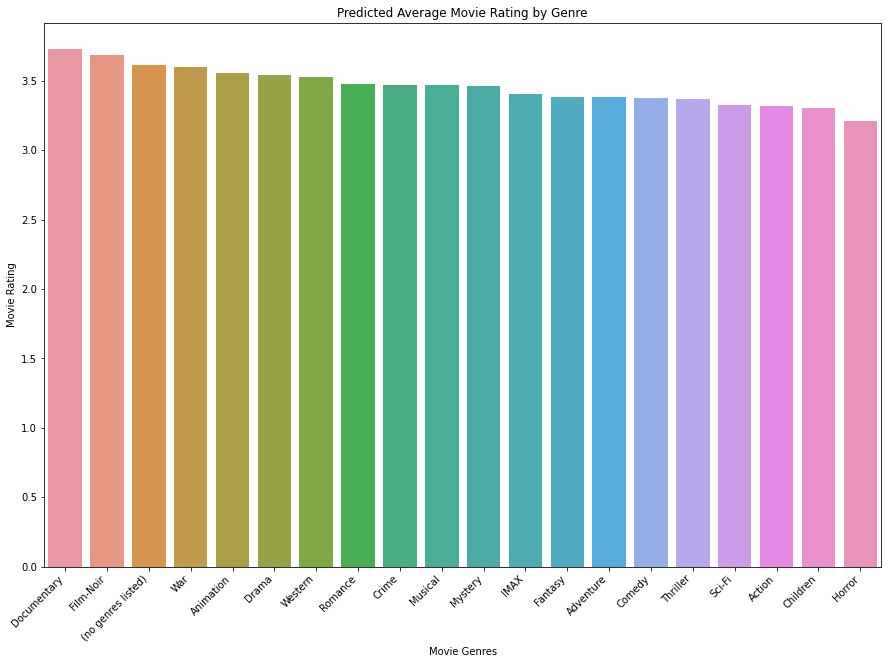

In [46]:
fig,ax = plt.subplots(figsize=(15,10))
sns.barplot(x = 'genres', y = 'movie_rating', data=merged_movies_df)
plt.xticks(rotation=45)

plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.title('Predicted Average Movie Rating by Genre')
plt.xlabel('Movie Genres')
plt.ylabel('Movie Rating');

The bar plot above shows how the recommendation system predicts the ratings of different movie genres for one user. 